In [79]:
%matplotlib nbagg
#Import required libraries
# from serial import Serial
import csv
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import os
# from drawnow import drawnow, figure
from scipy import stats
from scipy.signal import butter, lfilter, freqz, filtfilt
import pandas as pd
import math
from matplotlib import rcParams
import copy
rcParams.update({'figure.autolayout': True})

# Functions

In [141]:
def butter_filter(data, cutoff, order, fs):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    
    b, a = butter(order, normal_cutoff)  # , btype='low', analog=False
#     b, a = butter(3, 0.1)
    y = filtfilt(b, a, data)

    return y

def get_rolling_slope(csv_data,is_sensor_data):
    #Load sensor
    if is_sensor_data =='load':
        window_width_raw = 150
        window_width_flowrate = 10
        cutoff_1 = 0.02
        order_1 = 2 # 12
        datapnt_delay = 101
        fps = 1000/datapnt_delay
        
    elif is_sensor_data =='light':
        window_width_raw = 40
        window_width_flowrate = 10
        cutoff_1 = 0.03
        order_1 = 3  # 6 # 12
        datapnt_delay = 163
        fps = 1000/datapnt_delay
    else:
        fps = 1
    raw_data = []
    flow_rate = []
    flow_rate_filtered = []

    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width_raw*fps:
            curr_window_raw = raw_data[int(-window_width_raw*fps):]
            curr_window_raw_filtered = butter_filter(curr_window_raw, cutoff_1, order_1, fps)
            x =list(range(len(curr_window_raw_filtered)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window_raw_filtered)
            #print('curr_slope:', curr_slope)
            if is_sensor_data == 'load':
                raw_to_grams = 1/19000
                conversion_factor =60*fps
                density_milk = 1
                curr_flowrate = curr_slope*raw_to_grams*(1/density_milk)*conversion_factor*-1
            elif is_sensor_data == 'light':
                syringe_rad = 21.7/2 #Syringe radius in mm
                syringe_area = math.pi*(syringe_rad ** 2)
                conversion_factor = 0.06*fps
                curr_flowrate = curr_slope*syringe_area*conversion_factor
            flow_rate.append(curr_flowrate)
        else:
            flow_rate.append(0)
                
        cutoff_2 = 0.6
        order_2 = 6
        if len(flow_rate) > (window_width_raw+window_width_flowrate)*fps:
            curr_start = int(-window_width_flowrate*fps)
            curr_window_flowrate = flow_rate[curr_start:]
            
#             curr_window_flowrate_filtered = butter_filter(curr_window_flowrate, cutoff_2, order_2, fps)[0]
            curr_window_flowrate_filtered = np.mean(curr_window_flowrate)
            flow_rate_filtered.append(curr_window_flowrate_filtered)

        else:
            flow_rate_filtered.append(0)
    return flow_rate_filtered
#     return flow_rate




def get_rolling_slope_measured(csv_data,time):
    #Sampled every 5 seconds - real data
    fps = 1
    window_width = 3
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    density_milk = 1 
    conversion_factor = 60
    time_interval = 5 #5s between data recordings
    flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    data_mean, data_std = np.mean(flow_rate), np.std(flow_rate)
    # identify outliers
    cut_off = data_std * 0.7
    lower, upper = data_mean - cut_off, data_mean + cut_off
    indexes_to_remove = np.where((flow_rate< lower) | (flow_rate > upper))[0]
  
    flow_rate_filtered = np.delete(flow_rate, indexes_to_remove)#indexes_to_remove[0])
    time_filtered = np.delete(np.array(time),indexes_to_remove)
        
    return flow_rate_filtered,time_filtered




def get_time(csv_data,is_sensor_data):
    if is_sensor_data =='load':
        datapnt_delay = 101
        fps = 1000/datapnt_delay        
    elif is_sensor_data =='light':
        datapnt_delay = 163
        fps = 1000/datapnt_delay
    time = np.multiply(range(0,len(csv_data)),(1/fps))
    return time


def process_csv(csv_path,is_sensor_data):
    file = open(csv_path)
    csvreader = csv.reader(file)
    csv_data = np.asarray(list(csvreader))
    csv_data = np.asfarray(csv_data,float).flatten()
    if is_sensor_data =='load':
        cutoff = 0.01
        order = 6
        datapnt_delay = 101
        fps = 1000/datapnt_delay   
        #csv_data = butter_lowpass_filter(csv_data,cutoff,fps,order)
    elif is_sensor_data =='light':
        cutoff = 0.05
        order = 6
        datapnt_delay = 163
        fps = 1000/datapnt_delay
        #csv_data = butter_lowpass_filter(csv_data,cutoff,fps,order)
    return csv_data

# def process_csv(csv_path,is_sensor_data):
#     file = open(csv_path)
#     csvreader = csv.reader(file)
#     csv_data = np.asarray(list(csvreader))
#     csv_data = np.asfarray(csv_data,float).flatten()
#     return csv_data


# Read Data In

In [142]:
# Path to folder containing sensor data (csv file format)
csv_data_folder = r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'
#csv_data_folder = r'C:\Users\anne\Projects\FYDP\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'

#Read sensor data
csv_name_light1 = r'light_higher_1.csv'
csv_name_light2 = r'light_higher_2.csv'
csv_name_light3 = r'light_higher_3.csv'
csv_name_light4 = r'light_higher_4.csv'

csv_path_light1 = os.path.join(csv_data_folder, csv_name_light1)
csv_path_light2 = os.path.join(csv_data_folder, csv_name_light2)
csv_path_light3 = os.path.join(csv_data_folder, csv_name_light3)
csv_path_light4 = os.path.join(csv_data_folder, csv_name_light4)

csv_data_light1 = process_csv(csv_path_light1,'light')[630:2510]
csv_data_light2 = process_csv(csv_path_light2,'light')[470:2100]
csv_data_light3 = process_csv(csv_path_light3,'light')[368:]
csv_data_light4 = process_csv(csv_path_light4,'light')[140:]

time_light1 = get_time(csv_data_light1,'light')
time_light2 = get_time(csv_data_light2,'light')
time_light3 = get_time(csv_data_light3,'light')
time_light4 = get_time(csv_data_light4,'light')

#Read real sensor data
csv_name_light_measured = r'real_light_allresults.csv'
csv_path_light_measured = os.path.join(csv_data_folder, csv_name_light_measured)
csv_data_light_measured = pd.read_csv(csv_path_light_measured)

time_light_measured1 = csv_data_light_measured['Time (s)'][csv_data_light_measured['Trial 1 15 mL (g)'].notna()]
time_light_measured2 = csv_data_light_measured['Time (s)'][csv_data_light_measured['Trial 2 15 mL (g)'].notna()]
time_light_measured3 = csv_data_light_measured['Time (s)'][csv_data_light_measured['Trial 3 15 mL (g)'].notna()]
time_light_measured4 = csv_data_light_measured['Time (s)'][csv_data_light_measured['Trial 1 30 mL (g)'].notna()]

csv_data_light_measured1 = csv_data_light_measured['Trial 1 15 mL (g)'].dropna()
csv_data_light_measured2 = csv_data_light_measured['Trial 2 15 mL (g)'].dropna()
csv_data_light_measured3 = csv_data_light_measured['Trial 3 15 mL (g)'].dropna()
csv_data_light_measured4 = csv_data_light_measured['Trial 1 30 mL (g)'].dropna()

#Read load data
csv_name_load1 = r'LOAD_higher_1.csv'
csv_name_load2 = r'LOAD_higher_2.csv'
csv_name_load3 = r'LOAD_higher_3.csv'

csv_path_load1 = os.path.join(csv_data_folder, csv_name_load1)
csv_path_load2 = os.path.join(csv_data_folder, csv_name_load2)
csv_path_load3 = os.path.join(csv_data_folder, csv_name_load3)

csv_data_load1 = process_csv(csv_path_load1,'load')[650:]
csv_data_load2 = process_csv(csv_path_load2,'load')[650:]
csv_data_load3 = process_csv(csv_path_load3,'load')[650:]

time_load1 = get_time(csv_data_load1,'load')
time_load2 = get_time(csv_data_load2,'load')
time_load3 = get_time(csv_data_load3,'load')

#Read real experimental results from load data
csv_name_load_measured = 'real_load_allresults.csv'
csv_path_load_measured = os.path.join(csv_data_folder, csv_name_load_measured)
csv_data_load_measured = pd.read_csv(csv_path_load_measured)

time_load_measured1 = csv_data_load_measured['Time (s)'][csv_data_load_measured['Trial 1 30 mL (g)'].notna()]
time_load_measured2 = csv_data_load_measured['Time (s)'][csv_data_load_measured['Trial 2 30 mL (g)'].notna()]
time_load_measured3 = csv_data_load_measured['Time (s)'][csv_data_load_measured['Trial 3 30 mL (g)'].notna()]

csv_data_load_measured1 = csv_data_load_measured['Trial 1 30 mL (g)'].dropna()
csv_data_load_measured2 = csv_data_load_measured['Trial 2 30 mL (g)'].dropna()
csv_data_load_measured3 = csv_data_load_measured['Trial 3 30 mL (g)'].dropna()

# Light Sensor Raw Data Comparison 

<IPython.core.display.Javascript object>


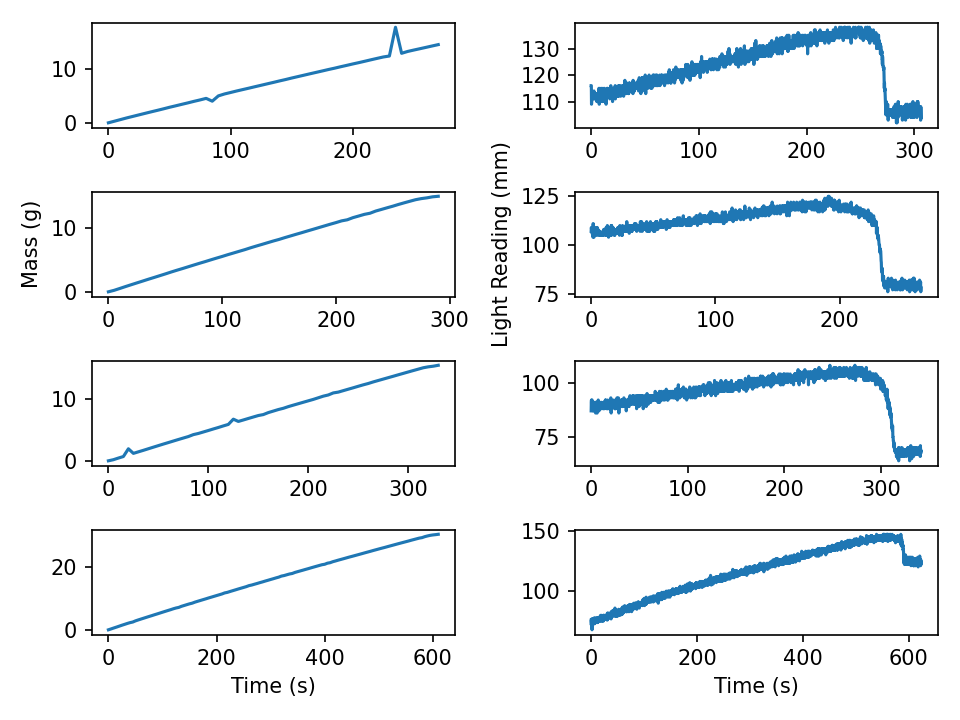

Text(0.5, 0, 'Time (s)')

In [143]:
#Read sensor data
fig, axs = plt.subplots(4,2)

axs[0, 0].plot(time_light_measured1,csv_data_light_measured1)
axs[0, 1].plot(time_light1,csv_data_light1)

axs[1, 0].plot(time_light_measured2,csv_data_light_measured2)
axs[1,0].set_ylabel('Mass (g)')
axs[1, 1].plot(time_light2,csv_data_light2)
axs[1,1].set_ylabel('Light Reading (mm)')

axs[2,0].plot(time_light_measured3,csv_data_light_measured3)
axs[2,1].plot(time_light3,csv_data_light3)

axs[3,0].plot(time_light_measured4,csv_data_light_measured4)
axs[3,0].set_xlabel('Time (s)')
axs[3,1].plot(time_light4,csv_data_light4)
axs[3,1].set_xlabel('Time (s)')


# Light Sensor Slope Data Comparison

<IPython.core.display.Javascript object>


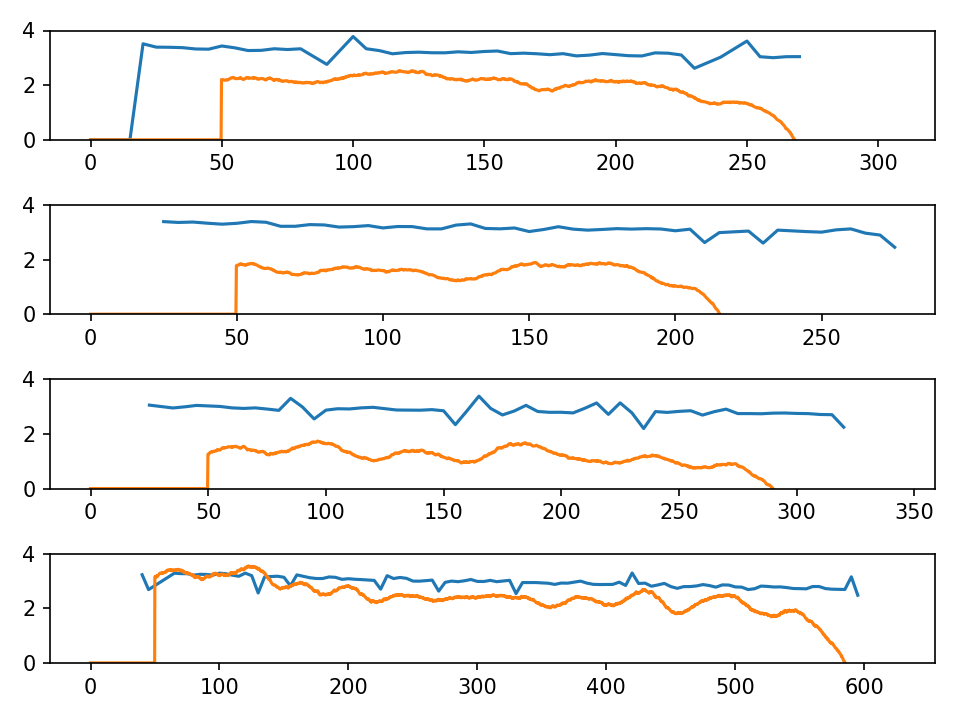

(0.0, 4.0)

In [144]:
fig, axs_2 = plt.subplots(4)
flow_rate_light1 = get_rolling_slope(csv_data_light1,'light')
flow_rate_light2 = get_rolling_slope(csv_data_light2,'light')
flow_rate_light3 = get_rolling_slope(csv_data_light3,'light')
flow_rate_light4 = get_rolling_slope(csv_data_light4,'light')

flow_rate_light_measured1,time_light_measured1_filt =get_rolling_slope_measured(csv_data_light_measured1,time_light_measured1)
flow_rate_light_measured2,time_light_measured2_filt =get_rolling_slope_measured(csv_data_light_measured2,time_light_measured2)
flow_rate_light_measured3,time_light_measured3_filt =get_rolling_slope_measured(csv_data_light_measured3,time_light_measured3)
flow_rate_light_measured4,time_light_measured4_filt =get_rolling_slope_measured(csv_data_light_measured4,time_light_measured4)

y_lim = [0,4]
axs_2[0].plot(time_light_measured1_filt,flow_rate_light_measured1)
axs_2[0].plot(time_light1,flow_rate_light1)
axs_2[0].set_ylim(y_lim)

axs_2[1].plot(time_light_measured2_filt,flow_rate_light_measured2)
axs_2[1].plot(time_light2,flow_rate_light2)  # time_light2
axs_2[1].set_ylim(y_lim)

axs_2[2].plot(time_light_measured3_filt,flow_rate_light_measured3)
axs_2[2].plot(time_light3,flow_rate_light3) # time_light3
axs_2[2].set_ylim(y_lim)

axs_2[3].plot(time_light_measured4_filt,flow_rate_light_measured4)
axs_2[3].plot(time_light4,flow_rate_light4) # time_light4
axs_2[3].set_ylim(y_lim)


# Load Sensor Raw Data Comparison 

<IPython.core.display.Javascript object>


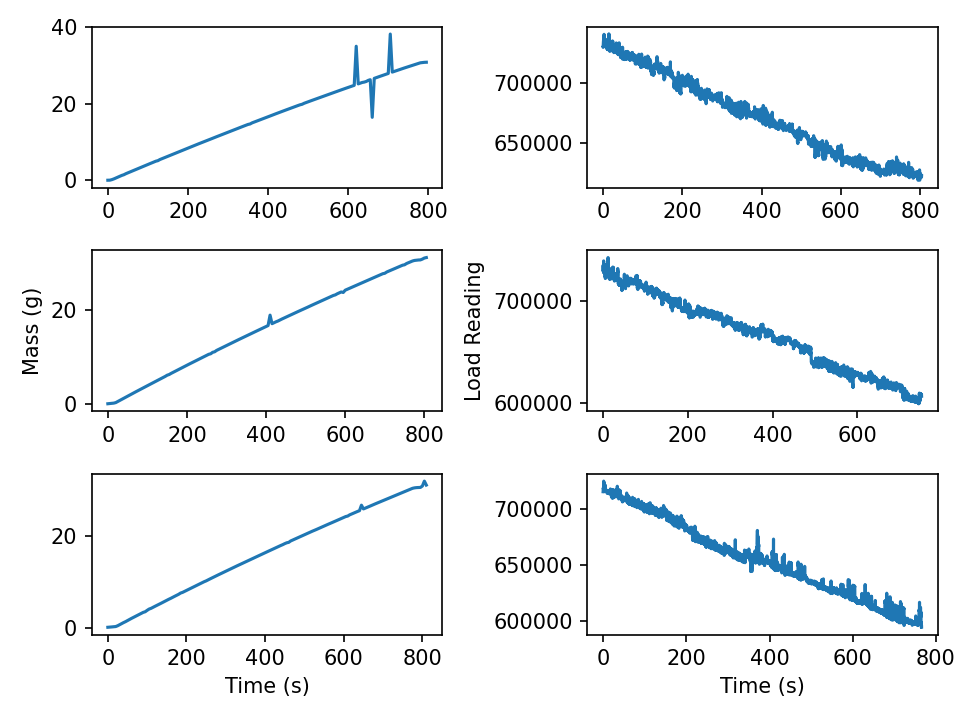

Text(0.5, 0, 'Time (s)')

In [145]:
#Read sensor data
fig, axs_3 = plt.subplots(3,2)
axs_3[0, 0].plot(time_load_measured1,csv_data_load_measured1)
axs_3[0, 1].plot(time_load1,csv_data_load1)

axs_3[1, 0].plot(time_load_measured2,csv_data_load_measured2)
axs_3[1,0].set_ylabel('Mass (g)')

axs_3[1, 1].plot(time_load2,csv_data_load2)
axs_3[1,1].set_ylabel('Load Reading')

axs_3[2,0].plot(time_load_measured3,csv_data_load_measured3)
axs_3[2,0].set_xlabel('Time (s)')

axs_3[2,1].plot(time_load3,csv_data_load3)
axs_3[2,1].set_xlabel('Time (s)')


# Load Sensor Slope Data Comparison

<IPython.core.display.Javascript object>


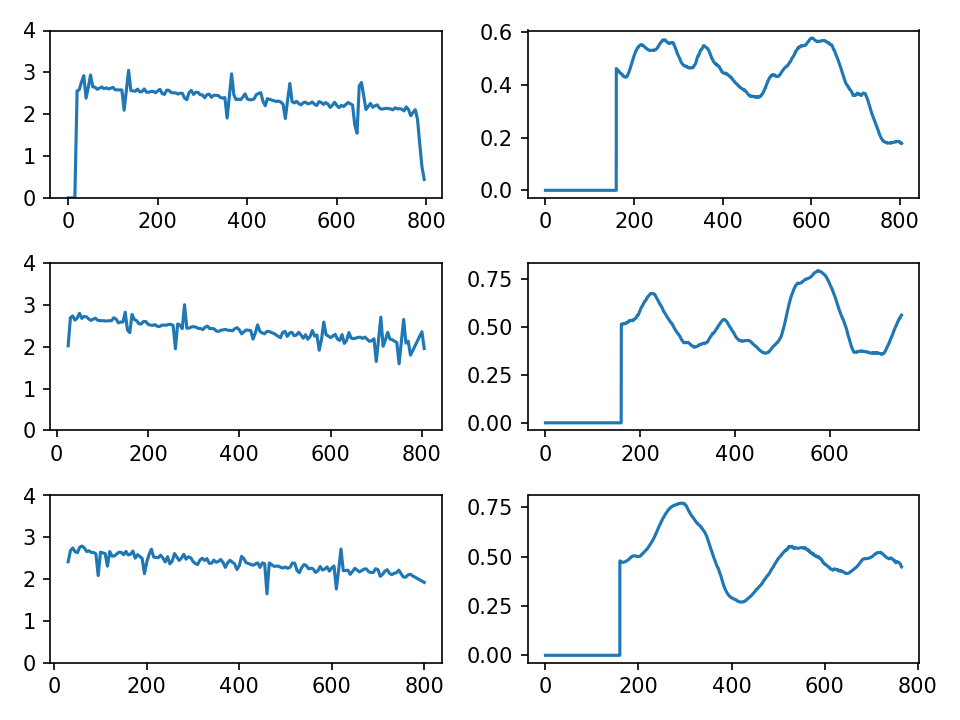

In [146]:
fig, axs_4 = plt.subplots(3,2)
flow_rate_load1 = get_rolling_slope(csv_data_load1,'load')
flow_rate_load2 = get_rolling_slope(csv_data_load2,'load')
flow_rate_load3 = get_rolling_slope(csv_data_load3,'load')

flow_rate_load_measured1,time_load_measured1_filt =get_rolling_slope_measured(csv_data_load_measured1,time_load_measured1)
flow_rate_load_measured2,time_load_measured2_filt =get_rolling_slope_measured(csv_data_load_measured2,time_load_measured2)
flow_rate_load_measured3,time_load_measured3_filt =get_rolling_slope_measured(csv_data_load_measured3,time_load_measured3)

y_lim = [0,4]
axs_4[0, 0].plot(time_load_measured1_filt,flow_rate_load_measured1)
axs_4[0,0].set_ylim(y_lim)
axs_4[0, 1].plot(time_load1,flow_rate_load1)
#axs_4[0,1].set_ylim([-1,5])

axs_4[1, 0].plot(time_load_measured2_filt,flow_rate_load_measured2)
axs_4[1,0].set_ylim(y_lim)
axs_4[1, 1].plot(time_load2,flow_rate_load2)
#axs_4[1,1].set_ylim([-1,5])
axs_4[2,0].plot(time_load_measured3_filt,flow_rate_load_measured3)
axs_4[2,0].set_ylim(y_lim)
axs_4[2,1].plot(time_load3,flow_rate_load3)
#axs_4[2,1].set_ylim([-1,5])



# Etc

In [ ]:
#Read real data
csv_name = r'\real_load_allresults.csv'
csv_path =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name
csv_data = pd.read_csv(csv_path)
slope = get_rolling_slope(csv_data['Trial 1 30 mL (g)'],False)
plt.figure()
plt.plot(csv_data['Time (s)'][22:120],slope[22:120])
plt.show()

In [ ]:
#Read sensor data
csv_name = r'\LOAD_higher_1.csv'
csv_path =r'C:\Users\a_hop\repos\fydp-neofeed\sensor_data\2022-02-03 Testing - Height Change Required'+csv_name
file = open(csv_path)
csvreader = csv.reader(file)
csv_data = np.asarray(list(csvreader))
csv_data = np.asfarray(csv_data,float).flatten()[670:]
slope = get_rolling_slope(csv_data,'load')
fig, (ax2) = plt.subplots(1)
ax2.plot(slope)
print(csv_data[0])
print(csv_data[len(csv_data)-1])

In [ ]:
#Make these plots look less shitty

#Trial 1
t1_start = 733130.0
t1_end = 622680.0
#Trial 2
t2_start = 747355
t2_end = 605708
#Trial 3
t3_start = 724357.0
t3_end = 598478.0
print(t1_end-t1_start)
print(t2_end-t2_start)
print(t3_end-t3_start)
diff_avg = (1/3)*((t1_end-t1_start)+(t2_end-t2_start)+(t3_end-t3_start))
diff_avg

In [ ]:
def get_rolling_slope_old(csv_data,is_sensor_data):
    
    #Load sensor
    if is_sensor_data =='load':
        datapnt_delay = 101
        fps = 1000/datapnt_delay
        window_width = 8
        
    elif is_sensor_data =='light':
        datapnt_delay = 163
        fps = 1000/datapnt_delay
        window_width = 8
        
    else:
        #Sampled every 5 seconds - real data
        fps = 1
        window_width = 3
    slope = []
    raw_data = []
    for i in range(len(csv_data)):
        val = csv_data[i]
        raw_data.append(val)
        if i>window_width*fps:
            curr_window = raw_data[int(-window_width*fps):]
            x =list(range(len(curr_window)))
            curr_slope, intercept, r, p, std_err = stats.linregress(x, curr_window)
            slope.append(curr_slope)
        else:
            slope.append(0)
         
    #Calculate flow rate depending on sensor data type
    if is_sensor_data == 'load':
        volume = 30
        raw_to_grams = volume/125879.0
        conversion_factor =60
        density_milk = 1
        flow_rate = np.multiply(slope,-1*raw_to_grams*(1/density_milk)*conversion_factor)
        
    elif is_sensor_data == 'light':
        syringe_rad = 21.7/2 #Syringe radius in mm
        syringe_area = math.pi*syringe_rad ** 2
        conversion_factor = 0.06
        flow_rate = np.multiply(slope,syringe_area*conversion_factor)
    else:
        density_milk = 1 
        conversion_factor = 60
        time_interval = 5 #5s between data recordings
        flow_rate = np.multiply(slope,(1/time_interval*(1/density_milk)*conversion_factor))
    
    return flow_rate

In [ ]:
sig = csv_data_light1[350:1500]
plt.figure(1)
plt.plot(sig)
plt.show()
x = list(range(len(sig)))
# print(sig)
curr_slope, intercept, r, p, std_err = stats.linregress(x, sig)
print(curr_slope)

In [ ]:
fig, axs_2 = plt.subplots(4,2)
flow_rate_light1 = get_rolling_slope(csv_data_light1,'light')
flow_rate_light2 = get_rolling_slope(csv_data_light2,'light')
flow_rate_light3 = get_rolling_slope(csv_data_light3,'light')
flow_rate_light4 = get_rolling_slope(csv_data_light4,'light')

flow_rate_light_measured1,time_light_measured1_filt =get_rolling_slope_measured(csv_data_light_measured1,time_light_measured1)
flow_rate_light_measured2,time_light_measured2_filt =get_rolling_slope_measured(csv_data_light_measured2,time_light_measured2)
flow_rate_light_measured3,time_light_measured3_filt =get_rolling_slope_measured(csv_data_light_measured3,time_light_measured3)
flow_rate_light_measured4,time_light_measured4_filt =get_rolling_slope_measured(csv_data_light_measured4,time_light_measured4)

y_lim = [0,4]
axs_2[0,0].plot(time_light_measured1_filt,flow_rate_light_measured1)
axs_2[0,0].set_ylim(y_lim)
# axs_2[0, 1].plot(time_light1,flow_rate_light1)
axs_2[0,1].plot(time_light1,flow_rate_light1)
axs_2[0,1].set_ylim(y_lim)

axs_2[1,0].plot(time_light_measured2_filt,flow_rate_light_measured2)
axs_2[1,0].set_ylim(y_lim)
axs_2[1,1].plot(time_light2,flow_rate_light2)  # time_light2
axs_2[1,1].set_ylim(y_lim)

axs_2[2,0].plot(time_light_measured3_filt,flow_rate_light_measured3)
axs_2[2,0].set_ylim(y_lim)
axs_2[2,1].plot(time_light3,flow_rate_light3) # time_light3
axs_2[2,1].set_ylim(y_lim)

axs_2[3,0].plot(time_light_measured4_filt,flow_rate_light_measured4)
axs_2[3,0].set_ylim(y_lim)
axs_2[3,1].plot(time_light4,flow_rate_light4) # time_light4
axs_2[3,1].set_ylim(y_lim)
